In [1]:
using Pkg
Pkg.activate(joinpath(Pkg.devdir(),"GridWorldPathFollowing"));

In [2]:
# using DataFrames, Gadfly
using Vec, LinearAlgebra
using GridWorldPathFollowing
using GraphUtils
using Random

In [3]:
include(joinpath(Pkg.devdir(),"GridWorldPathFollowing","test","notebooks","render_tools.jl"))

summarize_simulation (generic function with 1 method)

In [4]:
start_pt = VecE2(0.0,0.0)
start_time = 0.0
action_sequence = [SOUTH,EAST,WAIT,NORTH,EAST,WAIT,WAIT,EAST,EAST,SOUTH,SOUTH,WEST,NORTH,WEST,SOUTH,WEST,WEST]
# action_sequence = [EAST,WAIT,NORTH,EAST]
cell_width = 0.5
transition_time = 2.0
grid_path = construct_grid_world_path(start_pt,start_time,action_sequence,cell_width,transition_time)

base_traj = construct_trajectory(grid_path)
verify(base_traj)
capped_traj = cap_trajectory(base_traj)
verify(capped_traj)
# Optimize Velocity Profile
traj, t_vec, accel, vel, pos = optimize_velocity_profile(capped_traj;a_max=1.25);
verify(traj);

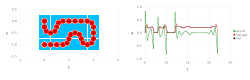

In [5]:
set_default_plot_size(25cm,8cm)
hstack(
    plot_traj_with_steps(base_traj,grid_path),
    plot_accel_vel_pos(base_traj,traj,t_vec,accel,vel,pos)
)

# Closed-loop tracking of Trajectory with optimized speed profile

In [6]:
t0 = get_start_time(traj)
get_dist(traj, t0),
get_position(traj,t0),
get_heading(traj,t0),
get_vel(traj, t0),
get_yaw_rate(traj,t0)

(-2.1865545619669821e-16, VecE2(0.000, 0.000), VecE2(0.000, -1.000), VecE2(0.000, -0.000), 0.0)

In [7]:
sim_model = UnicycleModel()
# controller = TrackingController(k0=2.0,k1=2.0)
controller = SwitchingController()
t0 = get_start_time(traj)
tf = get_end_time(traj)
dt = 0.05
Random.seed!(0)
state_pt = get_trajectory_point_by_time(traj, t0)
initial_state = [state_pt.pos.x, state_pt.pos.y, atan(state_pt.heading)] + .1*(1 .- rand(3))
states, cmds = simulate(sim_model,controller,traj,initial_state,t0,tf,dt)

time_vec = collect(t0:dt:tf);

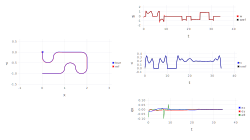

In [8]:
set_default_plot_size(25cm,14cm)
summarize_simulation(traj,states,cmds,time_vec)

# Tracking stationary spinning paths

In [9]:
c = VecE2(0.0,0.0)
r = 0.0
θ1 = 0.0
w = 1.0
dt = 1.0
T = 4
traj = Trajectory([ArcTrajectory(c,r,θ1+w*(t-1)*dt,w*dt,TimeInterval(dt*(t-1),dt*t)) for t in 1:T])
verify(traj)

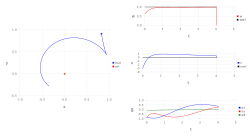

In [10]:
sim_model = UnicycleModel()
controller = SwitchingController()
t0 = 0.0
tf = get_end_time(traj)
dt = 0.05
state_pt = get_trajectory_point_by_time(traj, t0)
Random.seed!(0)
initial_state = [state_pt.pos.x, state_pt.pos.y, atan(state_pt.heading)] + 1.0*rand(3)
states, cmds = simulate(sim_model,controller,traj,initial_state,t0,tf,dt)

time_vec = collect(t0:dt:tf)
set_default_plot_size(25cm,14cm)
summarize_simulation(traj,states,cmds,time_vec)

# Track a Multi-Stage Composite Path with a turn-in-place in the middle

In [11]:
cell_width = 1.0
transition_time = 2.0
grid_path1 = construct_grid_world_path(VecE2(0.0,0.0),0.0,
    [SOUTH,EAST,WAIT,NORTH],cell_width,transition_time)
traj1 = construct_trajectory(grid_path1)
Δt = 2.0 # time between end of traj1 and start of traj2
grid_path2 = construct_grid_world_path(get_end_pt(traj1),get_end_time(traj1)+Δt,
    [EAST,SOUTH,EAST,WAIT,NORTH],cell_width,transition_time)
traj2 = construct_trajectory(grid_path2)

base_traj = stitch_trajectories(traj1,traj2;buffer=[0.1,0.1])
verify(base_traj)

traj, t_vec, accel, vel, pos = optimize_velocity_profile(base_traj;a_max=1.25);

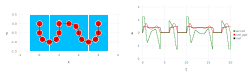

In [12]:
set_default_plot_size(25cm,8cm)
hstack(
    plot_traj_with_steps(base_traj,GridWorldPath( grid_path1.start_pt, grid_path1.start_time,
            vcat(grid_path1.waypoints,grid_path2.waypoints),cell_width )),
    plot_accel_vel_pos(base_traj,traj,t_vec,accel,vel,pos)
)

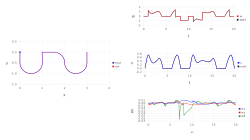

In [13]:
sim_model = UnicycleModel()
controller = SwitchingController(pivoter=PivotController(kw=0.5,kp=2.0))
t0 = 0.0
tf = get_end_time(traj)
dt = 0.05
state_pt = get_trajectory_point_by_time(traj, t0)
initial_state = [state_pt.pos.x, state_pt.pos.y, atan(state_pt.heading)] + 0.01*rand(3)
states, cmds = simulate(sim_model,controller,traj,initial_state,t0,tf,dt)

time_vec = collect(t0:dt:tf)
set_default_plot_size(25cm,14cm)
summarize_simulation(traj,states,cmds,time_vec)

# Test PivotController with position offset

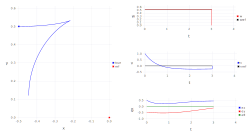

In [14]:
t0 = 0.0; tf = 3.0; dt=0.01;
state = [-0.5,0.5,0.0]
Δθ = π/2
traj = PivotTrajectory(VecE2(0.0,0.0),VecE2(1.0,0.0),Δθ,TimeInterval(t0,tf))
controller = PivotController(kw=0.5,kp=2.0)

time_vec = collect(t0:dt:tf)
states, cmds = simulate(sim_model,controller,traj,state,t0,tf,dt);
set_default_plot_size(25cm,14cm)
summarize_simulation(traj,states,cmds,time_vec)

# Test StabilizeController

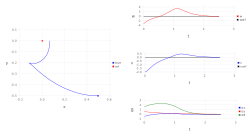

In [15]:
t0 = 0.0; tf = 2.5; dt=0.01;
state = [0.5,-0.5,0]
traj = WaitTrajectory(VecE2(0.0,0.0),VecE2(0.0,1.0),TimeInterval(t0,tf))
controller = StabilizeController(kw=2.0,kp=4.0)

time_vec = collect(t0:dt:tf)
states, cmds = simulate(sim_model,controller,traj,state,t0,tf,dt);
set_default_plot_size(25cm,14cm)
summarize_simulation(traj,states,cmds,time_vec)

# Test Reverse Controller

Test if UnicycleController can track a manually constructed trajectory with a ReverseTrajectory in it.

reverse_flag = !reverse_flag = true
reverse_flag = !reverse_flag = false


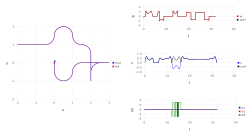

In [18]:
start_pt = VecE2(0.0,0.0)
start_time = 0.0
action_sequence = [SOUTH,EAST,WAIT,NORTH,EAST,EAST,WEST,SOUTH,NORTH,NORTH,WEST,NORTH,WEST,SOUTH,WEST,WEST]
# action_sequence = [EAST,NORTH,EAST]
cell_width = 1.0
transition_time = 2.0
grid_path = construct_grid_world_path(start_pt,start_time,
    action_sequence,cell_width,transition_time)

base_traj = construct_trajectory(grid_path)
verify(base_traj)

traj, t_vec, accel, vel, pos = optimize_velocity_profile(base_traj)
controller = SwitchingController()

t0 = get_start_time(traj); tf = get_end_time(traj); dt=0.01;
# t0 = 10.8; tf = 14.0; dt = 0.1;
time_vec = collect(t0:dt:tf)
state_pt = get_trajectory_point_by_time(traj, t0)
initial_state = [state_pt.pos.x, state_pt.pos.y, atan(state_pt.heading)] + 0.1*rand(3)
states, cmds = simulate(sim_model,controller,traj,initial_state,t0,tf,dt)
set_default_plot_size(25cm,14cm)
summarize_simulation(traj,states,cmds,time_vec)